# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 0) Further imports

In [2]:
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import accuracy_score, f1_score

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.grid_search import GridSearchCV

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1) Getting to know the data

In this section I got to know the data. A final questions had not been determined at this point. Rather I took notes of what I could potentially do to further cleanse the data and how to put them together to get further insights

## 1.1) Getting to know portfolio

In [3]:
#display first entries
portfolio.head(15)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Notes to portfolio:
- there is 4 channels: email, mobile, social, web
- 4 bogos, 4 discounts, 2 informational

Potential ToDos (notes):
- convert channels data into dummy data so they're easier to process
- convert id into offerid
- create additional variable: number of channels

## 1.2) Getting to know profile

In [4]:
# first entries
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# number of entries
profile.shape

(17000, 5)

In [6]:
# statistics of entries
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Potential ToDos (notes): 
- Convert membership to datetime to infer the amount of days the person has been a member
- change id to userid
- remove unplausible ages
- remove unplausible membership durations


## 1.3) Getting to know transcript

In [7]:
# first entries
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [8]:
# last entries
transcript.tail()

,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [9]:
# number of entries
transcript.shape

(306534, 4)

In [10]:
# overview of values per event
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

Notes to transcript:
- test was 714 hours long, i.e. 29 days and 18h

Potential ToDos (notes):
- convert event into dummies for easier handling
- convert value into dummies for easier handling and split between 'amount' and 'offer id'
- track time between offer and transaction
- remove dictionary in values (convert into different datatype)

# 2) Basic data cleansing
In this section I did basic cleansing of the data without yet knowing the final question I would like to answer.

## 2.1) Cleanse portofolio

In [11]:
# define cleansing function for portfolio

def cleanse_portfolio(portfolio):
    
    """ Cleanses the portfolio
    INPUT:
        portfolio (Pandas DataFrame object): the portfolio to be cleansed
    OUTPUT:
        clean_port (Pandas DataFrame object): the cleansed portfolio 
    """
    
    # copy dataframe
    clean_port=portfolio.copy()
    
    #copy column to create the dummies to keep the original column
    clean_port['type'] = clean_port['offer_type']
    
    #create dummies for offer_type
    clean_port=pd.get_dummies(clean_port, columns=['type'])
        
    #create dummies for channel and new variable: number of channels
    clean_port['channel_email']= clean_port['channels'].apply(lambda x:1 if 'email' in x else 0)
    clean_port['channel_mobile']= clean_port['channels'].apply(lambda x:1 if 'mobile' in x else 0)
    clean_port['channel_social']= clean_port['channels'].apply(lambda x:1 if 'social' in x else 0)
    clean_port['channel_web']= clean_port['channels'].apply(lambda x:1 if 'web' in x else 0)
    clean_port['no_channels']=clean_port['channel_email']+clean_port['channel_mobile']+clean_port['channel_web']+clean_port['channel_social']
    
    #remove original channels valiable
    clean_port.drop(columns=['channels'], inplace=True)
    
    #rename id into order_id and reward into theoretical_reward
    clean_port.rename(columns={'id': 'offer_id', 'reward': 'theoretical_reward'}, inplace=True)

    return clean_port

In [12]:
# perform cleansing
portfolio_clean=cleanse_portfolio(portfolio)

In [13]:
# display cleansed portfolio
portfolio_clean.head(12)

,difficulty,duration,offer_id,offer_type,theoretical_reward,type_bogo,type_discount,type_informational,channel_email,channel_mobile,channel_social,channel_web,no_channels
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0,3
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1,4
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1,3
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1,3
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1,2
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,0,1,0,1,1,1,1,4
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,0,1,0,1,1,1,1,4
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,1,1,1,1,0,3
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,0,0,1,1,1,1,4
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,0,1,1,0,1,3


## 2.2) Cleanse profile

### 2.2.1) Check plausibility of age distribution

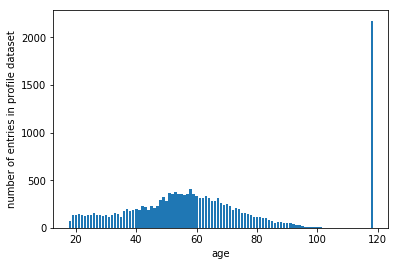

In [14]:
# Count values per age
age_distrib=profile['age'].value_counts().sort_index()

# visualize age distribution
plt.bar(age_distrib.index,age_distrib.values)
plt.xlabel('age')
plt.ylabel('number of entries in profile dataset')
plt.show()

Depending on key question identified later on I might decide in favor or against removing unplausible ages

### 2.2.2) Check pattern of NaNs

In [15]:
# Check pattern of NaNs
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [16]:
# remove NaNs
profile_nonans=profile.dropna()

In [17]:
# Check shape of cleaned profile dataframe
profile_nonans.shape

(14825, 5)

Conclusion 1: Those rows with NaN in column gender also have a NaN in income

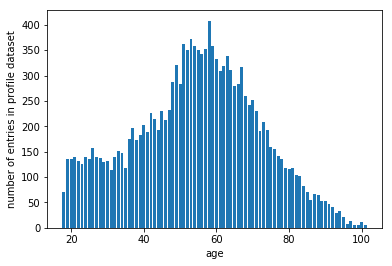

In [18]:
# Count values per age of cleaned profile dataset
age_distrib=profile_nonans['age'].value_counts().sort_index()

# visualize age distribution
plt.bar(age_distrib.index,age_distrib.values)
plt.xlabel('age')
plt.ylabel('number of entries in profile dataset')
plt.show()

Conclusion 2: Removing those rows with NaNs removes those rows with unplausible ages

### 2.2.3) Define cleansing function and cleanse data

In [19]:
def cleanse_profile(profile):
    """ Cleanses the profile: removes NaNs and implausible values, calculates the duration of membership, inserts new variable
        to summarize age, income and membership duration in classes
    INPUT:
        profile (Pandas DataFrame object): the profile to be cleansed
    OUTPUT:
        clean_profile (Pandas DataFrame object): the cleansed profile 
    """
    
    # copy dataframe
    clean_profile=profile.copy()
    
    #remove NaNs, in this case, automatically removes unplausible age values
    clean_profile.dropna(inplace=True)
    
    #infer the latest date of the test
    max_date=pd.to_datetime(clean_profile['became_member_on'].max(), format='%Y%m%d')
    
    #count days of membership in new column, remove old column
    clean_profile['duration_membership']=(max_date - pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d')).dt.days
    clean_profile.drop(columns=['became_member_on'], inplace=True)
    clean_profile.rename(columns={'id': 'person_id'}, inplace=True)
    
    #insert variables for classes
    clean_profile['age_class']=(clean_profile['age']/10).apply(np.floor)
    clean_profile['income_class']=(clean_profile['income']/10000).apply(np.floor)
    clean_profile['membership_class']=(clean_profile['duration_membership']/200).apply(np.floor)
    
    #define values of classes  
    clean_profile['age_class'].replace([0,1,2,3,4,5,6,7,8,9,10],['000 - 009','010 - 019','020 - 029','030 - 039','040 - 049','050 - 059','060 - 069','070 - 079','080 - 089','090 - 099', '100 - 109' ], inplace=True)
    clean_profile['income_class'].replace([3,4,5,6,7,8,9,10,11,12],['030k - 039k','040k - 049k','050k - 059k','060k - 069k','070k - 079k','080k - 089k','090k - 099k','100k - 109k','110k - 119k','120k - 129k'], inplace=True)
    clean_profile['membership_class'].replace([0,1,2,3,4,5,6,7,8,9],['0000 - 0200 days','0200 - 0400 days','0400 - 0600 days','0600 - 0800 days','0800 - 1000 days','1000 - 1200 days','1200 - 1400 days','1400 - 1600 days', '1600 - 1800 days','1800 - 2000 days'], inplace=True)
    
    return clean_profile

In [20]:
# perform cleansing
profile_clean=cleanse_profile(profile)

In [21]:
#display cleansed profile
profile_clean.head()

,age,gender,person_id,income,duration_membership,age_class,income_class,membership_class
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,050 - 059,110k - 119k,0200 - 0400 days
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,070 - 079,100k - 109k,0400 - 0600 days
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,91,060 - 069,070k - 079k,0000 - 0200 days
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,167,060 - 069,050k - 059k,0000 - 0200 days
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,257,050 - 059,050k - 059k,0200 - 0400 days


## 2.3) Cleanse transcript

### 2.3.1) Explore transcript

In [22]:
# display first entries
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
# explore transcript for one user
transcript.loc[transcript['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


Interim conclusion 1: One can receive the same offer multiple times. (Example: Here 0b1e1...)

Interim conclusion 2: The values column holds a dictionary that should be removed to improve analysis

### 2.3.2) Define and execute function to remove dictionary

In [24]:
def cleanse_transcript(transcript):
    """ Cleanses the transcript: removes the dictionary
    INPUT:
        transcript (Pandas DataFrame object): the transcript to be cleansed
    OUTPUT:
        clean_transcript (Pandas DataFrame object): the cleansed transcript 
    """
    
    # copy dataframe
    clean_transcript0=transcript.copy()
    
    # Isolate column with dictionary 
    transcript_values=clean_transcript0['value'].apply(pd.Series)
    
    # replace nans by 0
    transcript_values.replace(np.nan, 0, inplace=True)
    
    # merge columns for offer_id and offer id
    for index, row in transcript_values.iterrows():
        if row['offer id']==0:
            transcript_values.at[index,'offer id']=row['offer_id']
            
    #remove "duplicate" column
    transcript_values.drop(columns=['offer_id'], inplace=True)
    transcript_values.rename(columns={'offer id': 'offer_id'}, inplace=True)
    
    #switch back remaining 0s to nans
    transcript_values.replace(0, np.nan, inplace=True)
    
    #drop original column that held the dictionary
    clean_transcript0.drop(columns=['value'], inplace=True)
    
    #merge back cleansed up transcript values
    clean_transcript=pd.concat([clean_transcript0, transcript_values], axis=1)    
    
    return clean_transcript

In [25]:
transcript_clean=cleanse_transcript(transcript)

In [26]:
transcript_clean.head()

,event,person,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


## 3.0) Restructure transcript & merge data

The final question of the exercise will be to predict whether an offer will be successful (here:completed) or not, based on the properties of the offer and the data of the user the offer is sent to 

To prepare the analysis, the data needs to be reorganized as follows:
- The transcript needs to be reorganized in a way that all records pertaining to an individual offer are shown in one row
- Eventually, the data from profile and portfolio shold be merged with the transcript data

There will be exceptions that will be solved along the way

## 3.1) Excursion: further exploration of transcript data

Objective is to find out, whether all types of offers follow the same logic, i.e. that an offer can be received, viewed and completed

In [27]:
# Group transcript by offer id and event
transcript_clean.groupby(['offer_id', 'event']).agg(['count'])

person  time amount reward
                                                  count count  count  count
offer_id                         event                                     
0b1e1539f2cc45b7b9fa7c272da2e1d7 offer completed   3420  3420      0   3420
                                 offer received    7668  7668      0      0
                                 offer viewed      2663  2663      0      0
2298d6c36e964ae4a3e7e9706d1fb8c2 offer completed   5156  5156      0   5156
                                 offer received    7646  7646      0      0
                                 offer viewed      7337  7337      0      0
2906b810c7d4411798c6938adc9daaa5 offer completed   4017  4017      0   4017
                                 offer received    7632  7632      0      0
                                 offer viewed      4118  4118      0      0
3f207df678b143eea3cee63160fa8bed offer received    7617  7617      0      0
                                 offer viewed      4144  4144      0      0
4d5c57ea9a6940dd891ad53e9dbe8da0 offer completed   3331  3331      0   3331
                                 offer received    7593  7593      0      0
                                 offer viewed      7298  7298      0      0
5a8bc65990b245e5a138643cd4eb9837 offer received    7618  7618      0      0
                                 offer viewed      6687  6687      0      0
9b98b8c7a33c4b65b9aebfe6a799e6d9 offer completed   4354  4354      0   4354
                                 offer received    7677  7677      0      0
                                 offer viewed      4171  4171      0      0
ae264e3637204a6fb9bb56bc8210ddfd offer completed   3688  3688      0   3688
                                 offer received    7658  7658      0      0
                                 offer viewed      6716  6716      0      0
f19421c1d4aa40978ebb69ca19b0e20d offer completed   4296  4296      0   4296
                                 offer received    7571  7571      0      0
                                 offer viewed      7264  7264      0      0
fafdcd668e3743c1bb461111dcafc2a4 offer completed   5317  5317      0   5317
                                 offer received    7597  7597      0      0
                                 offer viewed      7327  7327      0      0

Interim conclusion: It can be clearly identified, whether a discount or a bogo offer has been successful because these type of offers yield 'offer completed' records in the transcript. This does not hold true for the information offers. These may result in a transaction, but are never recorded as 'completed'

## 3.2) Define and execute function that separates transcripts into the different record types and indexes the non-transaction related records

Define a function that does the following:
- splits the transcript into records belonging to monetary transactions, received offers, viewed offers and completed offers. Motivation: After splitting, the records can be reassembled in a way that all records belonging to one offer are contained in one row
- indexed the records belonging to received, viewed and completed offers in a way that the index identifies which records belong together

Unfortunately, the transcript does not tag which records belong to one offer. Assumptions need to be taken:
- Each received offer gets a unique index
- If a offer is viewed directly after a used has received an offer of the same kind, it is assumed that the user viewed the offer just received before
- If a offer is completed directly after a used has received an offer of the same kind, it is assumed that the user completed the offer just received before
- As users don't opt into offers, it is assumed, that they can view an offer after having (unconsciously) completed the offer
- If a user received, views and completed multiple offers of the same kind, it is assumed that:
- - The user views the offers in the same order as he receives them
- - The user completes the offers in the same order as he receives them

An illustration can be found in the next section

There will be exceptions that will be solved along the way

In [28]:
def split_and_index_transcript(transcript):
    """ indexes the records in the transcript to identify which records belong to the same offer and splits the transcript per record type
    INPUT:
        transcript (Pandas DataFrame object): the transcript to be split and indexed
    OUTPUT:
        transcript_offerreceived (Pandas DataFrame object): the indexed transcript, only containing received records
        transcript_offerviewed (Pandas DataFrame object): the indexed transcript, only containing viewed records
        transcript_offercompleted (Pandas DataFrame object): the indexed transcript, only containing completed records
        transcript_offerrelated (Pandas DataFrame object): the indexed transcript, only containing received, viewed and completed records
        transcript_transaction (Pandas DataFrame object): the transcript containing transaction related records
    """

    # split transcripts dataframe into respective parts for transactions and offer related rows
    transcript_transaction=transcript.loc[transcript['event'] == 'transaction']
    transcript_offerrelated=transcript.loc[transcript['event'] != 'transaction']
    
    #insert counter indices - to be used to enumerate rows
    transcript_offerrelated['counter_index1']=np.NaN
    transcript_offerrelated['counter_index2']=np.NaN

    #insert and define event number
    transcript_offerrelated['event_number']=transcript_offerrelated['event']
    transcript_offerrelated['event_number'].replace(['offer received','offer viewed','offer completed'],[1,2,3],inplace=True) 
    
    #sort values by 1) person, 2) offer_id, 3) event_number 4) time
    transcript_offerrelated.sort_values(['person', 'offer_id', 'event_number','time'], inplace=True)
    
    # enumerate rows, each received offer to get a new number. all transactions happening after this to obtain the same number
    counter_index1=0
    event_number_tracker=5
    offer_id_tracker=''
    person_tracker=''

    for index, row in transcript_offerrelated.iterrows():
        if (row['event']=='offer received' and event_number_tracker!=1) or (row['event']=='offer received' and row['offer_id']!= offer_id_tracker)  or (row['event']=='offer received' and row['person']!=person_tracker):
            counter_index1=counter_index1+1
        transcript_offerrelated.at[index,'counter_index1']=counter_index1
        event_number_tracker=row['event_number']
        offer_id_tracker=row['offer_id']
        person_tracker=row['person']
        
    # Insert counter that indicates cases where a user has received several offers of the same kind. Each, the received, the viewed and the completed offers are enumerated
    counter_index_tracker=0
    event_number_tracker=0

    for index, row in transcript_offerrelated.iterrows():
        if (row['counter_index1']!=counter_index_tracker or row['event_number']!=event_number_tracker):
            counter_index2=1
        else: 
            counter_index2=counter_index2+1
        transcript_offerrelated.at[index,'counter_index2']=counter_index2
        counter_index_tracker=row['counter_index1']
        event_number_tracker=row['event_number']
    
    #include composite index
    transcript_offerrelated['composite_index']=transcript_offerrelated['counter_index1'].astype(int).astype(str) + str('-') + transcript_offerrelated['counter_index2'].astype(int).astype(str)
    
    # split dataframe into those for received offers, viewed offers and completed offers
    transcript_offerreceived=transcript_offerrelated.loc[transcript_offerrelated['event'] == 'offer received']
    transcript_offerviewed=transcript_offerrelated.loc[transcript_offerrelated['event'] == 'offer viewed']
    transcript_offercompleted=transcript_offerrelated.loc[transcript_offerrelated['event'] == 'offer completed']
    
    return transcript_offerreceived, transcript_offerviewed, transcript_offercompleted, transcript_transaction, transcript_offerrelated
    

In [29]:
# execute creation of indexed and split transcripts
transcript_offerreceived, transcript_offerviewed, transcript_offercompleted, transcript_transaction, transcript_offerrelated = split_and_index_transcript(transcript_clean)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

### 3.2.1) Excursion: Illustration of indexing

As per the logic outlined above, it is assumed that:
- records 121508, 132398 and 132400 belong to the same offer and thus carry the index 22284-1
- records 10631 and 45261 belong to the same offer and thus carry the index 22285-1. This offer has been received and completed, but not viewed (e.g. not consciously completed)
- records 63831 and 83109 belong to the same offer and thus carry the index 22285-2. This offer has been received and completed, but not viewed (e.g. not consciously completed)
- records 161316, 242949, and 182130 belong to the same offer and thus carry the index 22286-1
- records 212197, 281428, and 281430 belong to the same offer and thus carry the index 22286-2
- records 255817, and 281431 belong to the same offer and thus carry the index 22286-3. This offer has been received and completed, but not viewed (e.g. not consciously completed)

In [30]:
#illustration of indexing
transcript_offerrelated.loc[transcript_offerrelated['person'] == '5a7136999fa240838c28e52359f6533d']


,event,person,time,offer_id,amount,reward,counter_index1,counter_index2,event_number,composite_index
121508,offer received,5a7136999fa240838c28e52359f6533d,336,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,22284.0,1.0,1,22284-1
132398,offer viewed,5a7136999fa240838c28e52359f6533d,348,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,22284.0,1.0,2,22284-1
132400,offer completed,5a7136999fa240838c28e52359f6533d,348,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,22284.0,1.0,3,22284-1
10630,offer received,5a7136999fa240838c28e52359f6533d,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,22285.0,1.0,1,22285-1
63831,offer received,5a7136999fa240838c28e52359f6533d,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,22285.0,2.0,1,22285-2
45261,offer completed,5a7136999fa240838c28e52359f6533d,114,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,22285.0,1.0,3,22285-1
83109,offer completed,5a7136999fa240838c28e52359f6533d,204,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,22285.0,2.0,3,22285-2
161316,offer received,5a7136999fa240838c28e52359f6533d,408,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,22286.0,1.0,1,22286-1
212197,offer received,5a7136999fa240838c28e52359f6533d,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,22286.0,2.0,1,22286-2
255817,offer received,5a7136999fa240838c28e52359f6533d,576,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,22286.0,3.0,1,22286-3


## 3.3) Create and execute function to combine received and viewed offers

In [31]:
#print checksum of total rows
transcript_transaction.shape[0] + transcript_offerreceived.shape[0] + transcript_offerviewed.shape[0] + transcript_offercompleted.shape[0]

306534

In [32]:
def combine_received_viewed(transcript_offerreceived, transcript_offerviewed):
    """ Combines the transcript with the received and viewed offers based on their composite_index
    INPUT:
        transcript_offerreceived (Pandas DataFrame object): the indexed transcript, only containing received records
        transcript_offerviewed (Pandas DataFrame object): the indexed transcript, only containing viewed records
    OUTPUT:
        transcript_receivedandviewed (Pandas DataFrame object): the indexed transcript, containing received and viewed records
    """
    
    #remove amount, reward, event_number
    transcript_offerreceived.drop(columns=['amount','reward', 'event_number'], inplace=True)

    #reorganize order of columns
    columnsTitles = ['composite_index', 'person', 'offer_id', 'event','time', 'counter_index1', 'counter_index2']
    transcript_offerreceived = transcript_offerreceived.reindex(columns=columnsTitles)
    
    #rename time & event
    transcript_offerreceived.rename(columns={'event': 'offer_received','time': 'time_received'}, inplace=True)
    
    #change values
    transcript_offerreceived['offer_received']=1
    
    #merge transcripts offerreceived and viewed
    transcript_receivedandviewed=pd.merge(transcript_offerreceived, transcript_offerviewed[['event','time','composite_index']], how='left',on='composite_index', sort=False)
    
    #rename time & event
    transcript_receivedandviewed.rename(columns={'event': 'offer_viewed','time': 'time_viewed'},inplace=True)
    
    #redefine values for offerviewed & time_viewed
    transcript_receivedandviewed.replace({'offer_viewed': {np.NaN: 0, 'offer viewed': 1}},inplace=True)

    return transcript_receivedandviewed

In [33]:
# execute joining of records pertaining to received and viewed offers
transcript_receivedandviewed=combine_received_viewed(transcript_offerreceived, transcript_offerviewed)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# print overview table of received and viewed records
transcript_receivedandviewed.head()

,composite_index,person,offer_id,offer_received,time_received,counter_index1,counter_index2,offer_viewed,time_viewed
0,1-1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,1.0,1.0,0,NaN
1,2-1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,336,2.0,1.0,1,372.0
2,3-1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,168,3.0,1.0,1,192.0
3,4-1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,4.0,1.0,1,456.0
4,5-1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,5.0,1.0,1,540.0


## 3.4) Create and execute function to combine received, viewed and completed offers

In [35]:
def combine_received_viewed(transcript_receivedandviewed, transcript_offercompleted):
    """ Combines the transcript with the received, viewed and completed offers offers based on their composite_index
    INPUT:
        transcript_receivedandviewed (Pandas DataFrame object): the indexed transcript that combines received and viewed offers
        transcript_offercompleted (Pandas DataFrame object): the indexed transcript, only containing completed records
    OUTPUT:
        transcript_receivedviewedandcompleted (Pandas DataFrame object): the indexed transcript, containing received, viewed and completed
    """
    
    #merge transcripts offerreceived and viewed
    transcript_receivedviewedandcompleted=pd.merge(transcript_receivedandviewed, transcript_offercompleted[['event','time','composite_index', 'reward']], how='left',on='composite_index', sort=False)
    
    #rename time & event
    transcript_receivedviewedandcompleted.rename(columns={'event': 'offer_completed','time': 'time_completed', 'person': 'person_id'},inplace=True)
    
    #redefine values for offerviewed & time_viewed
    transcript_receivedviewedandcompleted.replace({'offer_completed': {np.NaN: 0, 'offer completed': 1}}, inplace=True)
    
    return transcript_receivedviewedandcompleted

In [36]:
# execute merging of received, viewed and completed records
transcript_receivedviewedandcompleted = combine_received_viewed(transcript_receivedandviewed, transcript_offercompleted)

In [37]:
# show new table of received, viewed and completed records
transcript_receivedviewedandcompleted.head()

,composite_index,person_id,offer_id,offer_received,time_received,counter_index1,counter_index2,offer_viewed,time_viewed,offer_completed,time_completed,reward
0,1-1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,1.0,1.0,0,NaN,1,576.0,2.0
1,2-1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,336,2.0,1.0,1,372.0,0,NaN,NaN
2,3-1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,168,3.0,1.0,1,192.0,0,NaN,NaN
3,4-1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,4.0,1.0,1,456.0,1,414.0,5.0
4,5-1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,5.0,1.0,1,540.0,1,528.0,2.0


## 3.5) Check plausibility of results

In [38]:
def plausi_check(transcript_receivedviewedandcompleted):
    
    # check if there is really just max 3 entries per composite index - result needs to be 76277
    print('sum of rows: ')
    print(transcript_receivedviewedandcompleted.shape[0])
    
    # include time differences to check plausibility of results
    transcript_receivedviewedandcompleted['diff_viewed_received']=transcript_receivedviewedandcompleted['time_viewed']-transcript_receivedviewedandcompleted['time_received']    
    transcript_receivedviewedandcompleted['diff_completed_received']=transcript_receivedviewedandcompleted['time_completed']-transcript_receivedviewedandcompleted['time_received']
    transcript_receivedviewedandcompleted['diff_completed_viewed']=transcript_receivedviewedandcompleted['time_completed']-transcript_receivedviewedandcompleted['time_viewed']
    
    #print sum of received, viewed and completed offers
    print('sum of received offers: ')
    print(transcript_receivedviewedandcompleted['offer_received'].sum())
    print('sum of viewed offers: ')
    print(transcript_receivedviewedandcompleted['offer_viewed'].sum())
    print('sum of completed offers: ')
    print(transcript_receivedviewedandcompleted['offer_completed'].sum())
    
    # check plausibility of time differences
    print('sum negatives of time viewed minus time received: ')
    print(sum(n < 0 for n in transcript_receivedviewedandcompleted['diff_viewed_received']))
    print('sum negatives of time completed minus time received: ')
    print(sum(n < 0 for n in transcript_receivedviewedandcompleted['diff_completed_received']))
    print('sum negatives of time completed minus time viewed: ')
    print(sum(n < 0 for n in transcript_receivedviewedandcompleted['diff_completed_viewed']))
    
    transcript_receivedviewedandcompleted.drop(columns=['diff_viewed_received','diff_completed_received','diff_completed_viewed'], inplace=True)
    

In [39]:
# conduct plausibility check
plausi_check(transcript_receivedviewedandcompleted)

sum of rows: 
76277
sum of received offers: 
76277
sum of viewed offers: 
57725
sum of completed offers: 
33579
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
0
sum negatives of time completed minus time viewed: 
4371


Reminder: as per the original dataset, following sums should be obtained: 
- transaction        138953 (not included here)
- offer received      76277
- offer viewed        57725
- offer completed     33579

If there are negative values in the time differences, this means the following
- negative values in ['diff_viewed_received']: An offer has been first viewed and then received, this is not plausible
- negative values in ['diff_completed_received']: An offer has been first completed and then received, this is not plausible
- negative values in ['diff_completed_viewed']: An offer has been first completed and then received, this IS plausible and means that a user has unconsciously completed an offer

## 3.6) Determine successful informational events

We found out earlier, that the completion of informational offers is not tracked. However, one can regard informational offers as successful / completed if
- They have been viewed AND
- A transaction takes place during the time of their validity AND
- This transaction is not already completing another BOGO or discount offer


### 3.6.1) Determine those transactions that are NOT already completing a BOGO or discount offer

One can see in below illustration that there are transactions that take place at exactly the same time that a bogo of discount offer is completed. We will assume that these transactions take place as a result of respective bogo or discount offer.

We want to take these transactions out of the full list of transactions. 

THe remainder of the transactions will be assessed regarding whether they took place during the validity period of an informational offer.

In [40]:
#Illustration of event record for one person
transcript_clean.loc[transcript_clean['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,offer_id,amount,reward
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,NaN,22.16,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,NaN,8.57,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [41]:
def find_candidate_transactions(transcript_clean):
    """ Find those transactions that are NOT already completing a bogo or discount offer
    INPUT:
        transcript_clean (Pandas DataFrame object): clean transcript record
    OUTPUT:
        transcript_cand_comptrans_2 (Pandas DataFrame object): transaction record excluding those that are completing a discount or bogo offer
    """
    # copy clean dataset
    transcript_cand=transcript_clean.copy()
    
    # create transcript of completed offers and transactions only
    transcript_cand_completed=transcript_cand.loc[transcript_cand['event']=='offer completed']
    transcript_cand_transaction=transcript_cand.loc[transcript_cand['event']=='transaction']
    transcript_cand_comptrans=transcript_cand_completed.append(transcript_cand_transaction)
    
    #sort values by 1) person, 2) time, 3) event
    transcript_cand_comptrans.sort_values(['person','time','event'], inplace=True)
    
    # enumerate rows; all transactions that happen at the same time as a completed offer are flagged with a '1'
    transcript_cand_comptrans['counter']=99
    counter=0
    pre_event=''
    pre_time=''

    for index, row in transcript_cand_comptrans.iterrows():
            if (row['event']=='transaction' and row['time']==pre_time and pre_event=='offer completed'):
                counter=1
            transcript_cand_comptrans.at[index,'counter']=counter
            pre_event=row['event']
            pre_time=row['time']
            counter=counter+1
    
    # keep only those transaction records with a counter>1 that are not related to a bogo or discount offer
    transcript_cand_comptrans_1=transcript_cand_comptrans.loc[transcript_cand_comptrans['event']=='transaction']
    transcript_cand_comptrans_2=transcript_cand_comptrans_1.loc[transcript_cand_comptrans_1['counter']>1]
    
    #rename time into time_received
    transcript_cand_comptrans_2.rename(columns={'time': 'time_received'}, inplace=True)
    
    return transcript_cand_comptrans_2
    

In [42]:
#find candidate transactions that are not completing a bogo / discount offer
transaction_candidates=find_candidate_transactions(transcript_clean)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### 3.6.2) Determine successful / completed informational offers

We will regard an informational offer as completed / successful if
- It have been viewed AND
- A transaction takes place during the time of its validity AND
- This transaction is not already completing another BOGO or discount offer. The remaining candidates have been determined in previous section

In [43]:
def find_completed_info_offers(transcript_receivedandviewed, transaction_candidates):
    """ FInd those informational offers that can be regarded as completed
    INPUT:
        transcript_receivedandviewed (Pandas DataFrame object): a subset of the transcript holding information about received and viewed records
        transaction_candidates (Pandas DataFrame object): transaction record excluding those that are completing a discount or bogo offer
    OUTPUT:
        info_offers_4 (Pandas DataFrame object): Holds those transaction records that complete informational offers
    """
    
    #find those records that are informational offers
    info_offers=transcript_receivedandviewed[transcript_receivedandviewed['offer_id'].isin(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])]
    
    #insert validity period based on type of offer and starting at the time the offer was received 
    info_offers['valid_until']=info_offers['offer_id']
    info_offers['valid_until'].replace(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'], [24*4+info_offers['time_received'],24*3+info_offers['time_received']], inplace=True)
    
    #filter only those records that have been viewed
    info_offers_1=info_offers.loc[info_offers['offer_viewed']==1]
    
    #append list of candidate transactions that might relate to the informational offers
    info_offers_2=info_offers_1.append(transaction_candidates)
    
    #drop columns that aren't used and reengineer 'offer viewed' event
    info_offers_2.drop(columns=['amount', 'counter','offer_received', 'reward', 'time_viewed'], inplace=True)
    info_offers_2['event'].replace(np.nan,'offer viewed', inplace=True)
    
    #sort values by 1) person, 2) time_received, 3) event
    info_offers_2.sort_values(['person','time_received','event'], inplace=True)
    
    # enumerate rows: each transaction that takes place during the validity period of an informational offer is tagged with respective composite_index
    pre_event=''
    pre_time_min=''
    pre_time_max=''
    pre_composite_index=''

    for index, row in info_offers_2.iterrows():
            if (row['event']=='transaction' and pre_event=='offer viewed' and row['time_received']>=pre_time_min and row['time_received']<=pre_time_max):
                info_offers_2.at[index,'composite_index']=pre_composite_index
            pre_event=row['event']
            pre_time_min=row['time_received']
            pre_time_max=row['valid_until']
            pre_composite_index=row['composite_index']
    
    #remove nans in composite_index
    info_offers_2['composite_index'].replace(np.nan,0,inplace=True)
    
    #only retain transaction records that have been assigned a composite index
    info_offers_3=info_offers_2.loc[info_offers_2['composite_index']!=0]
    info_offers_4=info_offers_3.loc[info_offers_3['event']=='transaction']
    
    #filter only relevant information
    info_offers_4.drop(columns=['event', 'offer_id','offer_viewed', 'person', 'valid_until'], inplace=True)
    
    #rename to match final output table
    info_offers_4.rename(columns={'time_received': 'time_completed'}, inplace=True)
    
    #new colums: offer_completed
    info_offers_4['offer_completed']=1
    
    return info_offers_4

In [44]:
#find completed informational offers
completed_info_offers=find_completed_info_offers(transcript_receivedandviewed, transaction_candidates)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/opt/co

In [45]:
#show completed informational offers
completed_info_offers.head()

,composite_index,counter_index1,counter_index2,time_completed,offer_completed
233230,13-1,NaN,NaN,540,1
175779,17-1,NaN,NaN,426,1
34967,22-1,NaN,NaN,66,1
136532,21-1,NaN,NaN,360,1
27264,26-1,NaN,NaN,36,1


### 3.6.3) Merge completed info offers into full records overview

In [46]:
# Update index to composite index
transcript_rvc_incl_infooffers=transcript_receivedviewedandcompleted.set_index('composite_index')

In [47]:
# Update index to composite index
completed_info_offers_indexupdate=completed_info_offers.set_index('composite_index')

In [48]:
# update full transcript
transcript_rvc_incl_infooffers.update(completed_info_offers_indexupdate)

In [49]:
# check plausibility of results
plausi_check(transcript_rvc_incl_infooffers)

sum of rows: 
76277
sum of received offers: 
76277
sum of viewed offers: 
57725
sum of completed offers: 
40336.0
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
0
sum negatives of time completed minus time viewed: 
6287


Number of completed records and those that have been completed unconsciously increases. That is plausible

## 3.7) Merge transcript with portfolio and profile

In [50]:
# reminder: transcript columns
transcript_rvc_incl_infooffers.columns

Index(['person_id', 'offer_id', 'offer_received', 'time_received',
       'counter_index1', 'counter_index2', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward'],
      dtype='object')

In [51]:
# bring back composite index
transcript_rvc_incl_infooffers['composite_index'] = transcript_rvc_incl_infooffers.index

In [52]:
transcript_rvc_incl_infooffers

,person_id,offer_id,offer_received,time_received,counter_index1,counter_index2,offer_viewed,time_viewed,offer_completed,time_completed,reward,composite_index
composite_index,,,,,,,,,,,,
1-1,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,1.0,1.0,0,NaN,1.0,576.0,2.0,1-1
2-1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,336,2.0,1.0,1,372.0,0.0,NaN,NaN,2-1
3-1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,168,3.0,1.0,1,192.0,0.0,NaN,NaN,3-1
4-1,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,4.0,1.0,1,456.0,1.0,414.0,5.0,4-1
5-1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,5.0,1.0,1,540.0,1.0,528.0,2.0,5-1
6-1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,168,6.0,1.0,1,216.0,0.0,NaN,NaN,6-1
6-2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,1,576,6.0,2.0,1,630.0,0.0,NaN,NaN,6-2
7-1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,408,7.0,1.0,1,432.0,1.0,576.0,5.0,7-1
8-1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,168,8.0,1.0,1,186.0,1.0,252.0,3.0,8-1


In [53]:
#merge transcript with portfolio. Use left join as there are no Nans in portfolio
trans_port=pd.merge(transcript_rvc_incl_infooffers, portfolio_clean, how='left',on='offer_id', sort=False)

In [54]:
#show result
trans_port.head()

,person_id,offer_id,offer_received,time_received,counter_index1,counter_index2,offer_viewed,time_viewed,offer_completed,time_completed,...,offer_type,theoretical_reward,type_bogo,type_discount,type_informational,channel_email,channel_mobile,channel_social,channel_web,no_channels
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,1.0,1.0,0,NaN,1.0,576.0,...,discount,2,0,1,0,1,1,0,1,3
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,336,2.0,1.0,1,372.0,0.0,NaN,...,informational,0,0,0,1,1,1,0,1,3
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,168,3.0,1.0,1,192.0,0.0,NaN,...,informational,0,0,0,1,1,1,1,0,3
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,4.0,1.0,1,456.0,1.0,414.0,...,bogo,5,1,0,0,1,1,1,1,4
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,5.0,1.0,1,540.0,1.0,528.0,...,discount,2,0,1,0,1,1,1,1,4


In [55]:
#merge joined list of transcript and portfolio with profile. Use inner join in order to remove records that cannot be assigned an income or plausble age 
trans_port_prof=pd.merge(trans_port, profile_clean, how='inner',on='person_id', sort=False)

In [56]:
#show result
trans_port_prof.head()

,person_id,offer_id,offer_received,time_received,counter_index1,counter_index2,offer_viewed,time_viewed,offer_completed,time_completed,...,channel_social,channel_web,no_channels,age,gender,income,duration_membership,age_class,income_class,membership_class
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,576,1.0,1.0,0,NaN,1.0,576.0,...,0,1,3,33,M,72000.0,461,030 - 039,070k - 079k,0400 - 0600 days
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,336,2.0,1.0,1,372.0,0.0,NaN,...,0,1,3,33,M,72000.0,461,030 - 039,070k - 079k,0400 - 0600 days
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,168,3.0,1.0,1,192.0,0.0,NaN,...,1,0,3,33,M,72000.0,461,030 - 039,070k - 079k,0400 - 0600 days
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,408,4.0,1.0,1,456.0,1.0,414.0,...,1,1,4,33,M,72000.0,461,030 - 039,070k - 079k,0400 - 0600 days
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,504,5.0,1.0,1,540.0,1.0,528.0,...,1,1,4,33,M,72000.0,461,030 - 039,070k - 079k,0400 - 0600 days


In [57]:
# reminder: trans_port_prof columns
trans_port_prof.columns

Index(['person_id', 'offer_id', 'offer_received', 'time_received',
       'counter_index1', 'counter_index2', 'offer_viewed', 'time_viewed',
       'offer_completed', 'time_completed', 'reward', 'composite_index',
       'difficulty', 'duration', 'offer_type', 'theoretical_reward',
       'type_bogo', 'type_discount', 'type_informational', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'no_channels', 'age',
       'gender', 'income', 'duration_membership', 'age_class', 'income_class',
       'membership_class'],
      dtype='object')

In [58]:
plausi_check(trans_port_prof)

sum of rows: 
66501
sum of received offers: 
66501
sum of viewed offers: 
49860
sum of completed offers: 
38351.0
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
0
sum negatives of time completed minus time viewed: 
6000


In [59]:
trans_port_prof.set_index(['composite_index'], inplace=True)

Decrease of numbers due to inner join with profile

### 3.7.1) Determine completions outside of validity

We will find records in which the completion time is after the offer has expired. As stated before, completion records cannot be unambiguously assigned to offers and therefore assumptions were taken. In cases an offer is completed after offer expiry, the assumptions was obviously incorrect. We will identify respective completion records and reassign them in this section

In [60]:
def identify_unplausible_completions(trans_port_prof):
    """ Identify those records that hold a completion date outside of the offer validity
    INPUT:
        trans_port_prof (Pandas DataFrame object): joined table holding all transcript, offer and portfolio information and containing missasigned completion offers
    OUTPUT:
        unplausible_completions (Pandas DataFrame object): table holding only those records that have unplausible completion times
    """
    # copy dataframe with unplausible values
    unplausible_completions=trans_port_prof.copy()
    
    #insert tracker that indicates unplausible completions
    unplausible_completions['valid_until']=unplausible_completions['time_received']+24*unplausible_completions['duration']
    unplausible_completions['diff_valid_completed']=unplausible_completions['valid_until']-unplausible_completions['time_completed']
    
    #select needed columns
    unplausible_completions=unplausible_completions[['offer_completed', 'time_completed','reward','counter_index1', 'counter_index2', 'diff_valid_completed']]
    
    #select only unplausible rows
    unplausible_completions=unplausible_completions.loc[unplausible_completions['diff_valid_completed']<0]
    
  
    #reduce to needed columns only
    columnsTitles = ['offer_completed', 'time_completed', 'reward']
    unplausible_completions=unplausible_completions.reindex(columns=columnsTitles)
    
    unplausible_completions['offer_completed']=0
    unplausible_completions['time_completed']=0
    unplausible_completions['reward']=0
    
    return unplausible_completions

In [61]:
unplausible_completions= identify_unplausible_completions(trans_port_prof)

In [62]:
unplausible_completions.head()

,offer_completed,time_completed,reward
composite_index,,,
58-1,0,0,0
138-1,0,0,0
164-1,0,0,0
186-1,0,0,0
295-1,0,0,0


### 3.7.2) Remove unplausible completions

In this step the unplausible completion records will be removed from the consolidated dataset. They will be attached to a plausible record in the next section.

In [63]:
def plausibility_update(trans_port_prof, unplausible_completions):
    """ Identify those records that hold a completion date outside of the offer validity
    INPUT:
        trans_port_prof (Pandas DataFrame object): joined table holding all transcript, offer and portfolio information and containing missassigned completion offers
        unplausible_completions (Pandas DataFrame object): table holding indices of completion records that were assigned outside of validity period
    OUTPUT:
        trans_port_prof_interim (Pandas DataFrame object): joined table holding all  transcript, offer and portfolio information and excluding missassigned completion offers
    """
    
    trans_port_prof_interim=trans_port_prof.copy()
    trans_port_prof_interim.update(unplausible_completions)
    
    return trans_port_prof_interim

In [64]:
plausi_check(trans_port_prof)

sum of rows: 
66501
sum of received offers: 
66501
sum of viewed offers: 
49860
sum of completed offers: 
38351.0
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
0
sum negatives of time completed minus time viewed: 
6000


In [65]:
# remove unplausible completion entries
trans_port_prof_interim=plausibility_update(trans_port_prof, unplausible_completions)

In [66]:
plausi_check(trans_port_prof_interim)

sum of rows: 
66501
sum of received offers: 
66501
sum of viewed offers: 
49860
sum of completed offers: 
37179.0
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
665
sum negatives of time completed minus time viewed: 
6891


### 3.7.3) Attach completed offers in a plausible manner

Previous section removed those completion records that were missassigned outside the validity period of the offer. 

Again, there is no way to clearly assign a completion record to an offer. We only know, that for the identified records the assumption was wrong that offers are completed in the same order that they are received.

Rather, some records might not be completed and the completion records belongs to an offer received later. As an illustration, a user might
- receive 3 offers of the same kind
- complete 2 offers of the same kind

As per previous assumption, the completed offers would be assigned to the first 2 received offers. However, we identified that this allocation mechanism was not always plausible. Hence, for those records that were unplausible, we will move the completion records to an offer that was received later.

In [67]:
def plausibilize_completions(transcript_offercompleted, unplausible_completions):
    """ Re-assign completion records that were previously miss-assigned based on offer validity
    INPUT:
        transcript_offercompleted (Pandas DataFrame object): slice of original transcripts dataframe only holding the completed offers
        unplausible_completions (Pandas DataFrame object): table holding indices of completion records that were assigned outside of validity period
    OUTPUT:
        trans_port_prof_reassigned (Pandas DataFrame object): joined table holding all  transcript, offer and portfolio information and reassigned completion offers
    """
    
    #update unplausible completions to only hold index and flag
    unplausible_completions.rename(columns={'reward': 'flag'}, inplace=True) 
    unplausible_completions['flag']='affected'   
    unplausible_completions.drop(columns=['offer_completed','time_completed'], inplace=True)
    
    #unclude unplausibility flag in original transcript data
    update_completed=pd.merge(transcript_offercompleted, unplausible_completions, how='left',on='composite_index', sort=False)
    
    # flag all 
    previous_flag=''
    previous_counter_index1=''

    # flag all completion records that will be moved to a later transaction
    for index, row in update_completed.iterrows():
            if (previous_flag=='affected' and row['counter_index1']==previous_counter_index1):
                update_completed.at[index,'flag']='affected'
            previous_flag=row['flag']
            previous_counter_index1=row['counter_index1']
            
    # filter the affected rows only
    update_completed=update_completed.loc[update_completed['flag']=='affected']
    
    #update the index to attach to a later record
    update_completed['counter_index2']=update_completed['counter_index2']+1
    update_completed['composite_index']=update_completed['counter_index1'].astype(int).astype(str) + str('-') + update_completed['counter_index2'].astype(int).astype(str)
    
    #filter on needed columns and update column entries, set composite index as index
    columnsTitles = ['composite_index', 'time','reward']
    update_completed=update_completed.reindex(columns=columnsTitles)
    update_completed['offer_completed']=1
    update_completed.rename(columns={'time': 'time_completed'}, inplace=True)
    update_completed.set_index(['composite_index'], inplace=True)
    
    return update_completed

In [68]:
completed_records_update=plausibilize_completions(transcript_offercompleted, unplausible_completions)

In [69]:
trans_port_prof_interim_2=plausibility_update(trans_port_prof_interim, completed_records_update)

## 3.8) Finishing touches to dataset & include prediction variable

In [70]:
plausi_check(trans_port_prof_interim_2)

sum of rows: 
66501
sum of received offers: 
66501
sum of viewed offers: 
49860
sum of completed offers: 
38350.0
sum negatives of time viewed minus time received: 
0
sum negatives of time completed minus time received: 
614
sum negatives of time completed minus time viewed: 
6951


- bring back np.nan values for 'time_viewed' and 'time_completed' in cases the offer hasn't been viewed / complated
- reorder columns and delete counter_index1, counter_index2 and reward
- remove remaining rows where an offer in complated after its validity (it is 43 rows, and making up any further assumptions of how to remedy these rows will be far-fetched)

In [71]:
# bring back np.nan values for 'time_viewed' and 'time_completed' in cases the offer hasn't been viewed / complated
trans_port_prof_interim_2['time_viewed_new']=trans_port_prof_interim_2['offer_viewed']
trans_port_prof_interim_2['time_completed_new']=trans_port_prof_interim_2['offer_completed']

trans_port_prof_interim_2['time_viewed_new'].replace([0,1],[np.nan,trans_port_prof_interim_2['time_viewed']],inplace=True)
trans_port_prof_interim_2['time_completed_new'].replace([0,1],[np.nan,trans_port_prof_interim_2['time_completed']],inplace=True)

trans_port_prof_interim_2.drop(columns=['time_viewed', 'time_completed'],inplace=True)

trans_port_prof_interim_2.rename(columns={'time_viewed_new':'time_viewed', 'time_completed_new':'time_completed'},inplace=True)

In [72]:
#delete counter_index1, counter_index2 and reward
trans_port_prof_interim_2.drop(columns=['counter_index1', 'counter_index2', 'reward'], inplace=True)

In [73]:
#reorder columns
columnsTitles = ['person_id', 'offer_id', 'offer_received', 'time_received',
       'offer_viewed', 'time_viewed', 'offer_completed', 'time_completed', 'difficulty', 'duration',
       'offer_type', 'theoretical_reward', 'type_bogo', 'type_discount',
       'type_informational', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'no_channels', 'age', 'gender',
       'income', 'duration_membership', 'age_class', 'income_class',
       'membership_class']
trans_port_prof_interim_2=trans_port_prof_interim_2.reindex(columns=columnsTitles)

In [74]:
#remove remaining rows where an offer is complated after its validity - 43 cases
trans_port_prof_interim_2['valid_until']=trans_port_prof_interim_2['time_received']+24*trans_port_prof_interim_2['duration']
trans_port_prof_interim_2['diff_valid_completed']=trans_port_prof_interim_2['valid_until']-trans_port_prof_interim_2['time_completed'] 
trans_port_prof_interim_2['diff_valid_completed'].replace(np.nan, 1, inplace=True)
trans_port_prof_interim_2=trans_port_prof_interim_2.loc[trans_port_prof_interim_2['diff_valid_completed']>=0]

### 3.8.1) Include prediction variable

An offer should be regarded as successful if:
- it has been completed
- it has been viewed
- it has been viewed before it has been completed

In [75]:
# include prediction variable
trans_port_prof_interim_2['offer_successful']=''
trans_port_prof_interim_2['offer_successful'] = np.where((trans_port_prof_interim_2['offer_completed']==1) & (trans_port_prof_interim_2['offer_viewed']==1) & (trans_port_prof_interim_2['time_completed']-trans_port_prof_interim_2['time_viewed']>=0), 1, 0)

In [76]:
trans_port_prof_interim_2[['offer_viewed','time_viewed','offer_completed','time_completed','offer_successful']]

,offer_viewed,time_viewed,offer_completed,time_completed,offer_successful
composite_index,,,,,
1-1,0,NaN,1.0,576.0,0
2-1,1,372.0,0.0,NaN,0
3-1,1,192.0,0.0,NaN,0
4-1,1,456.0,1.0,414.0,0
5-1,1,540.0,1.0,528.0,0
7-1,1,432.0,1.0,576.0,1
8-1,1,186.0,1.0,252.0,1
9-1,1,6.0,0.0,NaN,0
10-1,1,354.0,0.0,NaN,0


In [77]:
df_full=trans_port_prof_interim_2.copy()

### 3.8.2) Final preparations of dataset for prediction

remove those variables that I don't want to establish a dependency on
- channel_email as all offers are sent via email
- person_id
- offer_received, time_received, offer_viewed, time_viewed, offer_completed, time_completed
- age_class, income_class, membership_class
- valid_until, diff_valid_completed

Trandform categorial variables gender and offer id into numeric valies

In [78]:
df_for_pred=df_full.copy()

In [79]:
# remove variables that are not needed
df_for_pred.drop(columns=['offer_type','channel_email', 'person_id', 'offer_received', 'time_received', 'offer_viewed', 'time_viewed', 'offer_completed', 'time_completed', 'age_class', 'income_class', 'membership_class', 'valid_until', 'diff_valid_completed'], inplace=True)

In [80]:
#transform gender into numeric values
df_for_pred['gender'].replace(['M','O','F'], [-1,0,1], inplace=True)

In [81]:
# transform offer ID into dummies
df_for_pred['offer_id'].replace(['2906b810c7d4411798c6938adc9daaa5','3f207df678b143eea3cee63160fa8bed', '5a8bc65990b245e5a138643cd4eb9837', 'f19421c1d4aa40978ebb69ca19b0e20d', 'fafdcd668e3743c1bb461111dcafc2a4', '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '0b1e1539f2cc45b7b9fa7c272da2e1d7','2298d6c36e964ae4a3e7e9706d1fb8c2'],['disc_r2_d7', 'info_r0_d4', 'info_r0_d3', 'bogo_r5_d5', 'disc_r2_d10', 'bogo_r5_d7', 'bogo_r10_d7', 'bogo_r10_d5', 'disc_r5_d10', 'disc_r3_d7'], inplace=True)
df_for_pred=pd.get_dummies(df_for_pred, columns=['offer_id'])

## 3.9) Spot check

In [82]:
transcript_clean.loc[transcript_clean['person']=='021adce38ab34ede96422ae107643fd5']

,event,person,time,offer_id,amount,reward
5480,offer received,021adce38ab34ede96422ae107643fd5,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
38791,offer viewed,021adce38ab34ede96422ae107643fd5,84,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
58700,offer received,021adce38ab34ede96422ae107643fd5,168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
67408,offer viewed,021adce38ab34ede96422ae107643fd5,168,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
70566,transaction,021adce38ab34ede96422ae107643fd5,174,NaN,12.89,NaN
70567,offer completed,021adce38ab34ede96422ae107643fd5,174,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
78190,transaction,021adce38ab34ede96422ae107643fd5,192,NaN,24.48,NaN
82260,transaction,021adce38ab34ede96422ae107643fd5,204,NaN,9.13,NaN
92788,transaction,021adce38ab34ede96422ae107643fd5,240,NaN,19.64,NaN
106404,transaction,021adce38ab34ede96422ae107643fd5,306,NaN,28.46,NaN


In [83]:
df_full.loc[df_full['person_id']=='021adce38ab34ede96422ae107643fd5']

,person_id,offer_id,offer_received,time_received,offer_viewed,time_viewed,offer_completed,time_completed,difficulty,duration,...,age,gender,income,duration_membership,age_class,income_class,membership_class,valid_until,diff_valid_completed,offer_successful
composite_index,,,,,,,,,,,,,,,,,,,,,
504-1,021adce38ab34ede96422ae107643fd5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,576,1,576.0,1.0,576.0,7,7,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,744,168.0,1
505-1,021adce38ab34ede96422ae107643fd5,2906b810c7d4411798c6938adc9daaa5,1,0,1,84.0,0.0,NaN,10,7,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,168,1.0,0
505-2,021adce38ab34ede96422ae107643fd5,2906b810c7d4411798c6938adc9daaa5,1,168,1,168.0,1.0,174.0,10,7,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,336,162.0,1
505-3,021adce38ab34ede96422ae107643fd5,2906b810c7d4411798c6938adc9daaa5,1,504,1,516.0,1.0,576.0,10,7,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,672,96.0,1
506-1,021adce38ab34ede96422ae107643fd5,3f207df678b143eea3cee63160fa8bed,1,336,1,336.0,1.0,342.0,0,4,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,432,90.0,1
507-1,021adce38ab34ede96422ae107643fd5,5a8bc65990b245e5a138643cd4eb9837,1,408,1,414.0,1.0,456.0,0,3,...,57,M,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days,480,24.0,1


In [84]:
profile_clean.loc[profile_clean['person_id']=='021adce38ab34ede96422ae107643fd5']

,age,gender,person_id,income,duration_membership,age_class,income_class,membership_class
7522,57,M,021adce38ab34ede96422ae107643fd5,65000.0,477,050 - 059,060k - 069k,0400 - 0600 days


# 4) Exploratory visualizations

- Objective is to predict whether an offer is successful / not successful based on the app user (demographics data) and the offer attributes
- To determine whether the successful completion rate actually differs based on these parameters, some exploratory visualizations based on these parameters are conducted

## 4.1) Basic correlations
Perform quick check of correlations with successful offer

In [85]:
#create correlations table
correlations=pd.DataFrame(df_for_pred.corr()['offer_successful'].drop(columns=['offer_successful']))
correlations.sort_values(by='offer_successful', inplace=True)
correlations.drop(['offer_successful'], inplace=True)

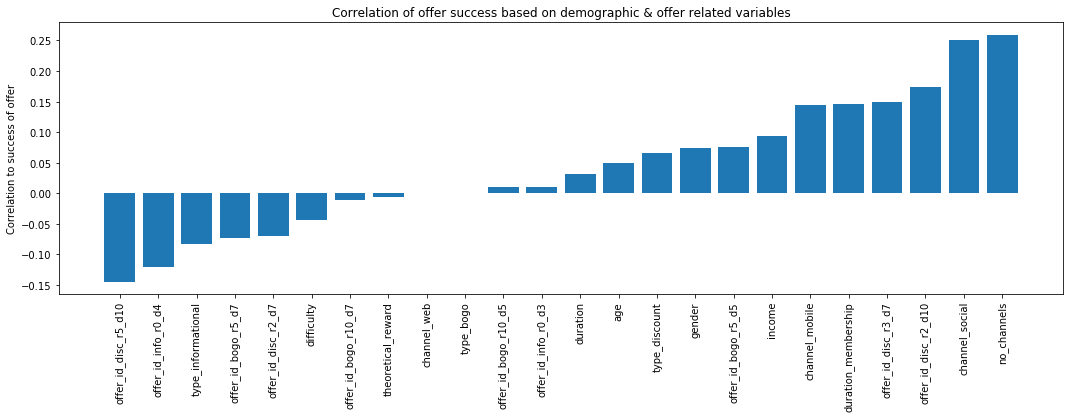

In [86]:
# Show visualizations of correlations
f, ax = plt.subplots(figsize=(18,5))
labels=correlations.index
x = np.arange(len(labels))

plt.bar(x,correlations['offer_successful'])


ax.set_ylabel('Correlation to success of offer')
ax.set_title('Correlation of offer success based on demographic & offer related variables')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')

plt.show()   

Interim conclusion: 
- The highest positive correlations of an offer's success are with the number of channels the offer was sent to, the fact if an offer has used the social channel and the fact whether an offer is a discount with reward 2 and duration 10, or with reward 3 and duration 7
- The highest negative correlations of an offer's success are with the fact that an offer is a discount with reward 5 and duration 10, with the fact that an offer is informational with the duration 4, and with the fact that an offer is informational

## 4.2) Offer success based on user characteristics
Here, I would like to visualize how the success of an offer depends on the demographic features of a user. 
In these visualzations I would like to compare the demographic feature of the total user portfolio and the portfolio of users that completed at least one offer.

I will use the clean data, i.e. the total user portfolio will already exclude the users that didn't indicate income or the ones with unplausible ages

### 4.2.1) Identify users with at least one completed offer within profile

In [87]:
# create users table
users=df_full.copy()
users=users[['person_id', 'age', 'age_class', 'gender', 'income', 'income_class', 'duration_membership','membership_class', 'offer_successful']]

In [88]:
#retain overview of unique users
users_unique=users.drop_duplicates(subset='person_id')

In [89]:
#create overview of uniques users that also completed at least one offer
users_successful=users.loc[users['offer_successful']==1]
users_successful_unique=users_successful.drop_duplicates(subset='person_id')

In [90]:
print(users_unique.shape)
print(users_successful_unique.shape)

(14820, 9)
(11649, 9)


As the sample of users that completed at least an offer is >75% of the total user baseline, the distribution of both groups based on demographic features is not assumed to differ significantly

### 4.2.2) Create funcion to display distribution charts based on demographics

In [91]:
def create_comp_chart(profile, profile_successful, dimension):
    """ Display distribution of total user portfolio vs. portfolio of users that at least complated one offer based on specific feature
    INPUT:
        profile (Pandas DataFrame object): table holding demographic information about all users that subscribed to the offer programm
        profile_successful (Pandas DataFrame object): table holding demographic information about all users completed at least one offer
    OUTPUT:
        -/- only display of chart
    """
    
    #Create percentage values
    distrib=profile[dimension].value_counts(dropna=False).sort_index()/profile.shape[0]
    distrib_successful=profile_successful[dimension].value_counts(dropna=False).sort_index()/profile_successful[dimension].shape[0]
    
    # Set size of figure
    f, ax = plt.subplots(figsize=(3,5))
    labels=distrib.index
    x = np.arange(len(labels))

    width = 0.4  # the width of the bars

    # visualize age distribution
    plt.bar(x-width/2,distrib.values,width,label='total user portfolio')
    plt.bar(x+width/2,distrib_successful.values,width, label='users that use offers')

    ax.set_xlabel(dimension)
    ax.set_ylabel('%-number of users with respective: ' + dimension)
    ax.set_title('Distribution of users based on: ' + dimension)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.legend()

    plt.show()        

### 4.2.3) Display comparisons based on demographic information of users

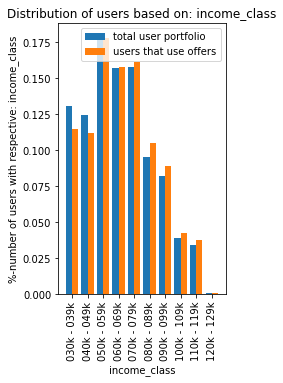

In [92]:
# create comparison based on user income
create_comp_chart(users_unique, users_successful_unique, 'income_class')

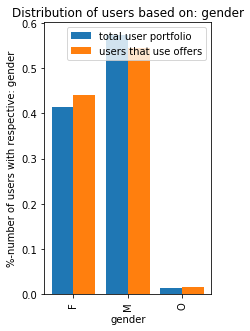

In [93]:
# create comparison based on user gender
create_comp_chart(users_unique, users_successful_unique, 'gender')

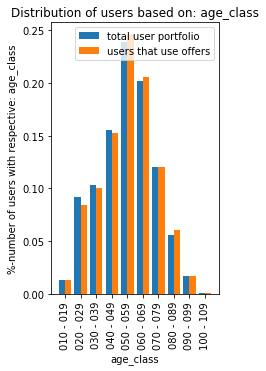

In [94]:
# create comparison based on user age
create_comp_chart(users_unique, users_successful_unique, 'age_class')

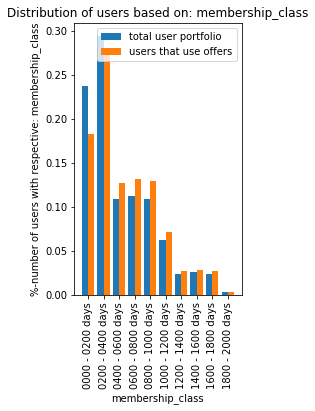

In [95]:
# create comparison based on user membership
create_comp_chart(users_unique, users_successful_unique, 'membership_class')

Interim conclusions:
- users with a higher income are slightly more likely to completed the received offers than those with a lower income
- there are more males enrolled to the program than females, however, females are more likely to complete the received offers than males
- most users enrolled in the program are between 50 - 59 years old. This is as well the age group that is most likely to complete the offers; in general, older users (>50 years) are more likely to accept the offers than younger
- Out of all factors, the duration of the membership seems to have the most impact on the likelyhood that a user completes an offer among all demographic factors. Users that have been enrolled for 400 days and more, are more likely to complete the received offers than other users

## 4.3) Analysis based on offer type
In this section we will compare the distribution of all offers that have been sent with the distribution of the successful offers based on the features of the offer

### 4.3.1) Prepare data

In [96]:
# create offers table
offers=df_full.copy()

In [97]:
# create table of successful offers
offers_successful=offers.loc[offers['offer_successful']==1]

### 4.3.2) Create function to display distribution charts based on offer properties

In [98]:
def create_comp_chart_offers(completion_analysis, completion_analysis_successful, dimension):
     
    #Create percentage values
    distrib=completion_analysis[dimension].value_counts(dropna=False).sort_index()/completion_analysis.shape[0]
    distrib_successful=completion_analysis_successful[dimension].value_counts(dropna=False).sort_index()/completion_analysis_successful[dimension].shape[0]
    
    # Set size of figure
    f, ax = plt.subplots(figsize=(3,5))
    labels=distrib.index
    x = np.arange(len(labels))

    width = 0.4  # the width of the bars

    # visualize age distribution
    plt.bar(x-width/2,distrib.values,width,label='all offers')
    plt.bar(x+width/2,distrib_successful.values,width, label='successful offers')

    ax.set_xlabel(dimension)
    ax.set_ylabel('% of offers with respective: ' + dimension)
    ax.set_title('Distribution of offers based on: ' + dimension)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.legend()

    plt.show()    
    

### 4.3.3) Display comparisons based offer features

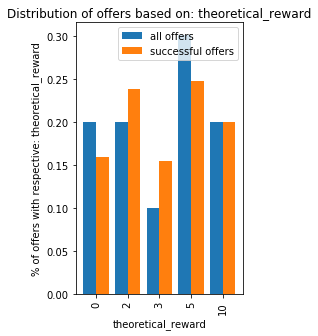

In [99]:
# create comparison based on reward
create_comp_chart_offers(offers, offers_successful,'theoretical_reward')

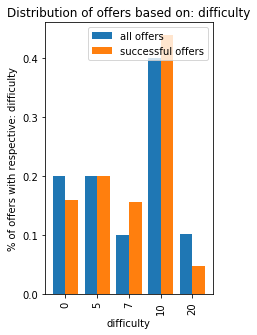

In [100]:
# create comparison based on difficulty
create_comp_chart_offers(offers, offers_successful,'difficulty')

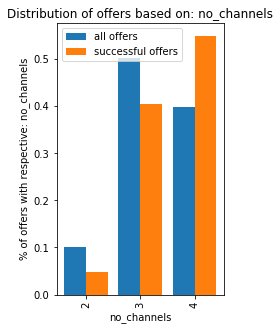

In [101]:
# create comparison based on number of channels the offer has been sent through
create_comp_chart_offers(offers, offers_successful,'no_channels')

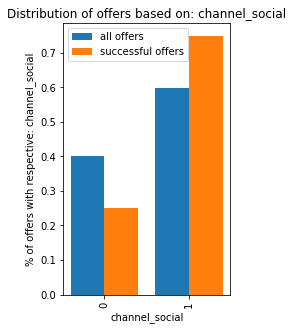

In [102]:
# create comparison based on whether offer has been distributed on social media
create_comp_chart_offers(offers, offers_successful,'channel_social')

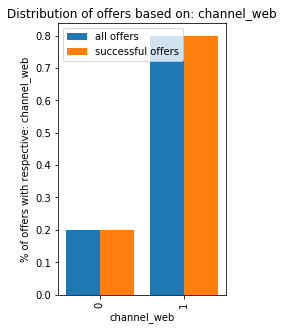

In [103]:
# create comparison based on whether offer has been distributed on the web channel
create_comp_chart_offers(offers, offers_successful,'channel_web')

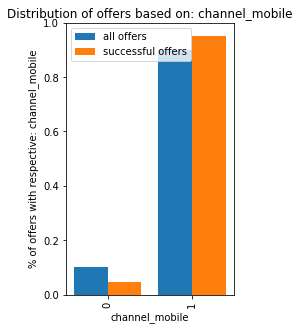

In [104]:
# create comparison based on whether offer has been distributed via mobile
create_comp_chart_offers(offers, offers_successful,'channel_mobile')

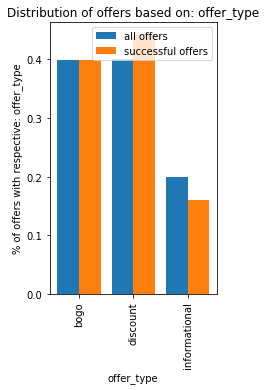

In [105]:
# create comparison based on offer type
create_comp_chart_offers(offers, offers_successful,'offer_type')

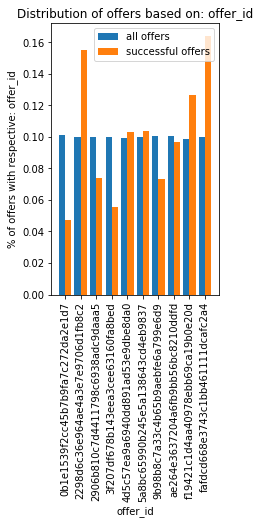

In [106]:
# create comparison based on offer id
create_comp_chart_offers(offers, offers_successful,'offer_id')

Interim conclusions:
- offers with a reward of 2 or 3 are more likely to be completed than with lower (0) or higher rewards (5, 10)
- offers with the difficulty 7 and 10 are more likely to be completed than with lower (0, 5) or higher difficulaties (20)
- offers that are distributed via all channels are more likely to be completed than those sent via fewer channels
- The social media channel is the most successful channel
- discount offers are most likely to be completed
- Across all offer types, the likelihood for offer completion is
  - hightest with the discount offers with reward 3 and duration7, with the discount offers with reward 2 and duration 10, and with the bogo offer with reward 5 and duration 5
  - lowest with the informational offers with duration 4 and with the discount offer with reward 5 and duration 10

# 5) PREDICTION MODEL

Objective of this section is to find the best algorithm to predict whether an offer is successful based on the demographic data of the user and the offer properties.

The best prediction will be assessed based on accuracy and f1-score.

The chosen predictor will eventually be improved via grid-search.

### 5.1) Data preparation

Data is normalized, the label is isolated, test & train sets are created

In [107]:
#split info features and labels
success_label = df_for_pred['offer_successful']
features_raw = df_for_pred.drop('offer_successful', axis = 1)

In [108]:
#normalize data
mm_scaler = MinMaxScaler()

feature_columns=features_raw.columns

features_norm=features_raw.copy()
features_norm[feature_columns]=mm_scaler.fit_transform(features_raw[feature_columns])

In [109]:
#create test and train sets
X_train, X_test, y_train, y_test = train_test_split(features_norm, 
                                                    success_label, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 53166 samples.
Testing set has 13292 samples.


## 5.2) Evaluate different classifiers for prediction
Test the following algorithms
- naive predictor; assumption: each offer is successful
- RandomForestClassifier
- AdaBoostClassifier
- Support Vector Machine
- LogisticRegression
- Gaussian Naive Bayes
- DecisionTreeClassifier
- KNeighborsClassifier

In [110]:
# NAIVE predictor performance
y_pred_train_naive = np.ones(len(y_train))
y_pred_test_naive = np.ones(len(y_test))

naive_pred_accuracy_test = accuracy_score(y_test, y_pred_test_naive)
naive_pred_f1score_test = f1_score(y_test, y_pred_test_naive)

naive_pred_accuracy_train = accuracy_score(y_train, y_pred_train_naive)
naive_pred_f1score_train = f1_score(y_train, y_pred_train_naive)

print("Naive predictor accuracy on test set: %.3f" % (naive_pred_accuracy_test))
print("Naive predictor f1-score on test set: %.3f" % (naive_pred_f1score_test))

print("Naive predictor accuracy on training set: %.3f" % (naive_pred_accuracy_train))
print("Naive predictor f1-score on training set: %.3f" % (naive_pred_f1score_train))

Naive predictor accuracy on test set: 0.399
Naive predictor f1-score on test set: 0.571
Naive predictor accuracy on training set: 0.398
Naive predictor f1-score on training set: 0.570


In [111]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    """"Perform prediction based on selected learner and evaluate performance
        INPUTS:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: labels training set
       - X_test: features testing set
       - y_test: labels testing set
       OUTPUTS:
       results (array): compilation of accuracy and f1-score of the prediction on train and test set
    """
    
    results = {}
    
    # Fit the learner to the training data
    learner = learner.fit(X_train, y_train)

    
    # Make predictions
    y_pred_test = learner.predict(X_test)
    y_pred_train = learner.predict(X_train)
     
    # Calculate & save metrics
    results['1: acc_test'] = accuracy_score(y_test,y_pred_test)
    results['2: f_test'] = f1_score(y_test, y_pred_test) 
    
    results['3: acc_train'] = accuracy_score(y_train, y_pred_train)
    results['4: f_train'] = f1_score(y_train, y_pred_train)
         
    return results

In [112]:
#instantiate classifiers to be tested and save in list
clf_RandomForest = RandomForestClassifier(random_state=42)
clf_AdaBoost = AdaBoostClassifier(random_state=42)
clf_SVM = svm.SVC(random_state=42, verbose=1)
clf_LogisticReg = LogisticRegression(random_state=42)
clf_GaussianNB = GaussianNB()
clf_DecisionTree = DecisionTreeClassifier(random_state=42)
clf_KNeighbors = KNeighborsClassifier()

classifiers=[clf_RandomForest,clf_AdaBoost, clf_SVM, clf_LogisticReg, clf_GaussianNB, clf_DecisionTree, clf_KNeighbors]

In [137]:
# Create table of results

results={}
results['Naive_predictor']={'1: acc_test': naive_pred_accuracy_test,'2: f_test': naive_pred_f1score_test,'3: acc_train': naive_pred_accuracy_train,'4: f_train': naive_pred_f1score_train}

for clf in classifiers:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf, X_train, y_train, X_test, y_test)
    
results=pd.DataFrame(results)

[LibSVM]

In [138]:
# display performance results of different algorithms
results

,Naive_predictor,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression,GaussianNB,DecisionTreeClassifier,KNeighborsClassifier
1: acc_test,0.399112,0.674616,0.688610,0.668823,0.662579,0.611797,0.646780,0.662052
2: f_test,0.570522,0.561226,0.559915,0.517748,0.516755,0.574959,0.547470,0.554895
3: acc_train,0.398168,0.946451,0.693281,0.675375,0.669921,0.621356,0.962250,0.774555
4: f_train,0.569557,0.931633,0.565922,0.527940,0.525331,0.585005,0.950492,0.702019


Conclusion: Both, RandomForestClassifier and AdaBoostClassifier perform well. I choose AdaBoostClassifier to perform grid search going forward

## 5.3) Grid Search - Improve AdaBoost

Note: I ran below grid search multiple times with different parameters. Below selection of parameters is the result of multiple iterations and will contain the best ones

In [115]:
# Define classifier for optimization
clf_AdaBoost = AdaBoostClassifier(random_state=42)

#Define parameters to evaluate
parameters = {'n_estimators': [29,30,31,32], 'learning_rate' : [0.9,1,1.1,1.2]}

# Run grid search
grid_obj = GridSearchCV(clf_AdaBoost, parameters, verbose=True)
grid_obj.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   46.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [29, 30, 31, 32], 'learning_rate': [0.9, 1, 1.1, 1.2]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [116]:
# Display best estimator
grid_obj.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=30, random_state=42)

In [117]:
# Re-define original classifier and classifier improved through grid-search
clf_AdaBoost_original = AdaBoostClassifier(random_state=42)
clf_AdaBoost_gridresults = AdaBoostClassifier(n_estimators=30, learning_rate=1, random_state=42)

# Run original and improved classifiers
grid_results={}
grid_results['AdaBoost_Original'] =train_predict(clf_AdaBoost_original, X_train, y_train, X_test, y_test)
grid_results['AdaBoost_GridResults'] =train_predict(clf_AdaBoost_gridresults, X_train, y_train, X_test, y_test)

#print results
pd.DataFrame(grid_results)

,AdaBoost_Original,AdaBoost_GridResults
1: acc_test,0.688610,0.687105
2: f_test,0.561128,0.559288
3: acc_train,0.693206,0.693733
4: f_train,0.567060,0.567987


Conclusion: The grid search was successful in the way that it improved the results on the training set. However, there was no improvement in the test set. The original parameters will be kept

## 5.4) Analyse Feature importance

Objective is to show which features of the dataset are most important to determine the label, i.e. describe the majority of the variance.

Text(0,0.5,'Feature')

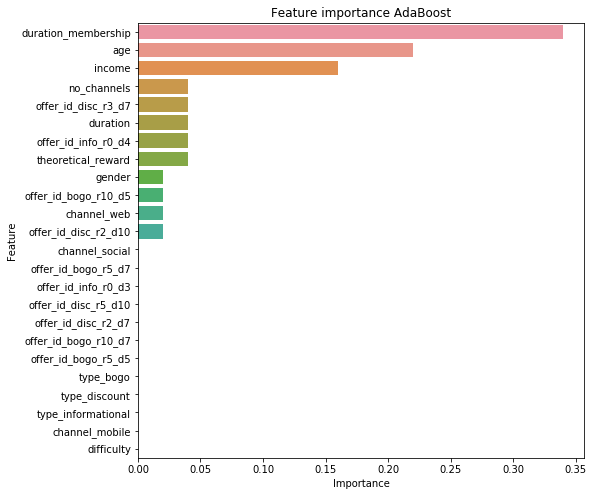

In [118]:
# Determine feature_importance as returned by selected AdaBoost classifier and sort descendingly
feature_importance = pd.DataFrame(list(zip(features_norm.columns,clf_AdaBoost_original.feature_importances_)),columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot importance per feature
plt.figure(figsize=(8, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature importance AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')

Conclusion 1: The most important featues to make a prediction whether an offer will be successful or not are the demographic features of the user (duration of the membership, age and income)

Conclusion 2: There are many features that do not contibute to the prediction. I suspect that the analysis is possible without quality loss if the offer_ids are excluded from the feature list. It should be possible to determine them as a linear combination of the offer type, reward, duration and difficulty. I will check in the next section

## 5.5) Excursion: Reduce number of features

Objective of this section is to check if an exclusion of the offer_id features reduces the quality of the prediction

In [119]:
# drop features relating to offer_ID
features_norm_noIDs=features_norm.copy()
features_norm_noIDs.drop(columns=['offer_id_bogo_r10_d7', 'offer_id_bogo_r5_d5', 'offer_id_bogo_r5_d7',
       'offer_id_disc_r2_d10', 'offer_id_disc_r2_d7', 'offer_id_disc_r3_d7',
       'offer_id_disc_r5_d10', 'offer_id_info_r0_d3', 'offer_id_info_r0_d4', 'offer_id_bogo_r10_d5'], inplace=True)

In [120]:
#create test and train sets based on updated feature list
X_train, X_test, y_train, y_test = train_test_split(features_norm_noIDs, 
                                                    success_label, 
                                                    test_size = 0.2, 
                                                    random_state = 42)


# Create table of results
results={}
results['Naive_predictor']={'1: acc_test': naive_pred_accuracy_test,'2: f_test': naive_pred_f1score_test,'3: acc_train': naive_pred_accuracy_train,'4: f_train': naive_pred_f1score_train}

for clf in classifiers:
    clf_name = clf.__class__.__name__
    results[clf_name]=train_predict(clf, X_train, y_train, X_test, y_test)
    
results_excursion=pd.DataFrame(results)

[LibSVM]

In [121]:
# Results of predictions based on feature list WITHOUT offer ID
results_excursion

,Naive_predictor,RandomForestClassifier,AdaBoostClassifier,SVC,LogisticRegression,GaussianNB,DecisionTreeClassifier,KNeighborsClassifier
1: acc_test,0.399112,0.674616,0.688610,0.668823,0.662579,0.611797,0.646780,0.662052
2: f_test,0.570522,0.561226,0.559915,0.517748,0.516755,0.574959,0.547470,0.554895
3: acc_train,0.398168,0.946451,0.693281,0.675375,0.669921,0.621356,0.962250,0.774555
4: f_train,0.569557,0.931633,0.565922,0.527940,0.525331,0.585005,0.950492,0.702019


In [122]:
# Reminder: Results of predictions based on feature list INCL. offer ID
results

{'Naive_predictor': {'1: acc_test': 0.39911224796870298,
  '2: f_test': 0.57052212722482121,
  '3: acc_train': 0.39816800210660946,
  '4: f_train': 0.56955673639604498},
 'RandomForestClassifier': {'1: acc_test': 0.67461631056274451,
  '2: f_test': 0.56122552500760892,
  '3: acc_train': 0.94645073919422185,
  '4: f_train': 0.93163316763921922},
 'AdaBoostClassifier': {'1: acc_test': 0.68860969003912131,
  '2: f_test': 0.55991493886230725,
  '3: acc_train': 0.69328142045668284,
  '4: f_train': 0.56592221896877581},
 'SVC': {'1: acc_test': 0.66882335239241653,
  '2: f_test': 0.51774758983347935,
  '3: acc_train': 0.67537523981491931,
  '4: f_train': 0.52793960777878068},
 'LogisticRegression': {'1: acc_test': 0.66257899488414085,
  '2: f_test': 0.51675466005818349,
  '3: acc_train': 0.66992062596396196,
  '4: f_train': 0.52533066457493705},
 'GaussianNB': {'1: acc_test': 0.61179656936503157,
  '2: f_test': 0.5749588138385503,
  '3: acc_train': 0.62135575367716211,
  '4: f_train': 0.58500

Text(0,0.5,'Feature')

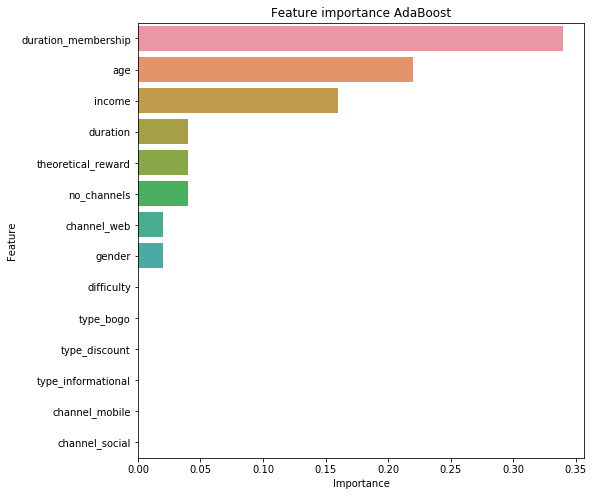

In [123]:
# Determine feature_importance as returned by selected AdaBoost classifier and sort descendingly
feature_importance = pd.DataFrame(list(zip(features_norm_noIDs.columns,clf_AdaBoost_original.feature_importances_)),columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot importance per feature
plt.figure(figsize=(8, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature importance AdaBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')

Conclusion: As assumed, the offer_ids do not add any additional value in the prediction whether a offer will be successful or not

# 6) Conclusions

The objective of the exercise was to determine a way to predict whether an offer sent to enrolled users of the Starbucks rewards app will be successful (i.e. completed) or not. Secondary objective was to find out which factors determine the success of an offer. Such prediction could be used to streamline the offer portfolio and only send offers to users that they are likely to completed. This will make sure that users do not feel 'disturbed' by irrelevant offers that they could regard as spam but rather feel happy about receiving a relevant offer.  

Following sections I will reflect on the approach, describe the results and implications & highlight further research needs.

## 6.1) Reflection on approach

In order to determine whether an offer can be regarded as successful or not, I spend a very long time on data cleansing. The reason for that was that existing data records do only indicate that offers are completed; they do not indicate which offer was completed in case a user has received and viewed multiple offers of the same type. Additionally, the records did not hold information on whether an informational offer has been completed or not. 

However, the assignment of completed offers to received and viewed offers was relevant to determine whether an offer can be regarded as successful or not. Just being completed doesn't make an offer successful, it might be completed unconsciously. Just if a user has also viewed the offer before completion it can be regarded as sucessful and one can assume that the user did the transaction because of the offer. 

In order to resolve this shortcoming, assumptions have been taken to map completed offers to received and viewed offers. The resulting data repository is plausible. However, even though it is plausible, it might not be a 100% accurate reflection of reality. This needs to be taken into consideration when reviewing the overall results. 

It is very likely that a simplified approach that does not take the success of an offer into consideration but only its completion would generate very similar business insights and that the exercise of data mapping did not justify the effort. 

## 6.2) Technical results & insights

Based on the features of the offer and the demographic information of the users, a prediction model of an offer's success was generated based on AdaBoost. The prediction has an accuracy of 68.7% which is better than the naive predictor (37.1%) and an f1-score of 56.1% which is approximately the same as the naive predictor (57.1%). These metrics are ok, not enormously good. Reasons why the prediction is not better could include:
- errors in the assumptions to map received, viewed and completed offers
- randomness induced by real human behavious 

However, one can infer a couple of key insights from the outcomes;

Based on the demographic information of the users, one can conclude that users with a high duration of membership in the reward program, users with a high income, females and best-agers are more likely to complete offers than other user groups. 

With regards to offer properties, offers with a reward of 2 or 3, with a difficulty of 7 and 10 and those that are distributed via all channels (email, social, web, mobile) are more likely to be completed than others.

All in all, the relative importance of the demographics features of the users is much more important to determine an offer's success than the offer properties. The relative importance of the demographic features membership duration, age and income to determine an offer's success is >70%.

## 6.3) Implications for Starbucks

Unfortunately, the prediction is probably not yet reliable enough to be used by Starbucks to filter which offers to send to which users. It should be used as an indication, but not as the only selection criterion.

However, based on the analysis, recommendations regarding the offer portfolio can be concluded;

In order to increase the probability of offers to be accepted, Starbucks should send all offers via all channels, or at least send all of them via the social channel, which seems to be most successful. Since the users are anyways enrolled in the program and therefore probably shared contact details of all channels, it should be possible to send all offers via all channels. There is no logical reason, why some offers are only sent via selected channels.

The more interesting implication is based on the insight, that the probability for an offer to become successful depends much more on the user characteristics then on the features of the offer. With this in mind, Starbucks should rethink the offer portfolio from a revenue impact perspective. Those offers associated with a high negative revenue impact should be removed as it is undesirable to give anything away for free if a user would equally respond to any other offer.

## 6.4) Suggested further analysis

In general, it would have been very helpful to have further insights into the business objective of Starbucks. Is the objective rather to attract as many customers as possible regardless of whether they're profitable or not? Is it to only attract highly profitable customers? Or is it to attract certain customer groups for image purposes? 

Regardless of the business objectives, further analysis can be conducted with the data at hand. As an example, the full set of monetary transactions could be analyzed, and the most profitable customer groups could be identified (so far, I have not looked at those transactions data not relating to any offer). 

For any kind of further analyses, it would be helpful if Starbucks would track further data in the transcript. As examples, it shouldn't be much technical effort to also track
- on which channel an offer has eventually been viewed
- which offer exactly has been viewed or complated in case multiple one of the same kind have been received

Eventually, I believe that more demographic analyses would make sense. For this purpose however, overall population data of the area in question would be helpful. The analyses which demographic groups participate in the rewards program as compared to the overall population is very interesting to determine whether Starbucks needs to find additional ways to contact customer groups currently not in focus.  
